Комірка 1: Імпорт бібліотек та налаштування

In [49]:
import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (22, 10)})
sns.set_style("darkgrid", {'axes.grid': True})



Комірка 2: Функція для відображення зображень



In [50]:
def show_image(img, cmap=None):
    plt.imshow(img, cmap=cmap, interpolation='bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()


In [1]:
import tensorflow as tf

def read_and_prepare_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img_gray = tf.image.rgb_to_grayscale(img)
    img_gray = tf.transpose(img_gray)
    return img_gray.numpy().squeeze()

def create_kernel(kernel_size, sigma, theta):
    assert kernel_size % 2
    half_size = kernel_size // 2

    kernel = np.zeros([kernel_size, kernel_size])
    sigma_x = sigma
    sigma_y = sigma * theta

    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - half_size
            y = j - half_size

            exp_term = np.exp(-x**2 / (2 * sigma_x) - y**2 / (2 * sigma_y))
            x_term = (x**2 - sigma_x**2) / (2 * math.pi * sigma_x**5 * sigma_y)
            y_term = (y**2 - sigma_y**2) / (2 * math.pi * sigma_y**5 * sigma_x)

            kernel[i, j] = (x_term + y_term) * exp_term

    kernel = kernel / np.sum(kernel)
    return kernel

def filter_image(img, kernel_size, sigma, theta):
    kernel = create_kernel(kernel_size, sigma, theta)
    img = tf.cast(img, tf.float32)  # Convert the input image to float32
    kernel = tf.cast(kernel, tf.float32)  # Convert the kernel to float32
    img_filtered = tf.nn.conv2d(tf.expand_dims(tf.expand_dims(img, 0), -1), tf.expand_dims(tf.expand_dims(kernel, -1), -1), strides=[1,1,1,1], padding='SAME')
    return img_filtered.numpy().squeeze()



def normalize_image(img):
    m, s = tf.nn.moments(tf.constant(img, dtype=tf.float32), axes=[0, 1])
    img = (img - m.numpy()) / s.numpy()
    img = ((img - np.min(img)) / (np.max(img) - np.min(img))) * 255
    return img.astype(np.uint8)

def apply_sum_function(img):
    return np.sum(img, axis=0)

def smooth(x, window_len=11, window='hanning'):
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat':  # moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

def find_peaks(arr, threshold):
    peaks = []
    peak_start = 0
    for i in range(1, len(arr) - 1):
        if arr[i] > threshold:
            if arr[i - 1] < arr[i] > arr[i + 1]:
                if peak_start == -1:
                    peak_start = i
                peaks.append(i) 
            elif peak_start != -1:
                peaks.append(peak_start)
                peak_start = -1
    return peaks

def merge_adjacent_peaks(peaks, min_distance):
    merged_peaks = []
    current_peak = peaks[0]
    for i in range(1, len(peaks)):
        if peaks[i] - current_peak < min_distance:
            current_peak = (current_peak + peaks[i]) // 2
        else:
            merged_peaks.append(current_peak)
            current_peak = peaks[i]

    merged_peaks.append(current_peak)
    return merged_peaks

def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines

def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is one of 'vertical', 'horizontal', default = 'vertical'")
    if orient == 'vertical':
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 25, i+1) # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
    else:
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(40, 1, i+1) # A grid of 40 rows x 1 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
    plt.show()

def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res

In [4]:
kernel_size=27
sigma=3
theta=9
smooth_window_len=4
threshold=0.3
peak_min_distance=20

image_path = 'Ukr/Franko_page.jpg'

In [5]:

img_gray = read_and_prepare_image(image_path)


AttributeError: module 'tensorflow' has no attribute 'io'

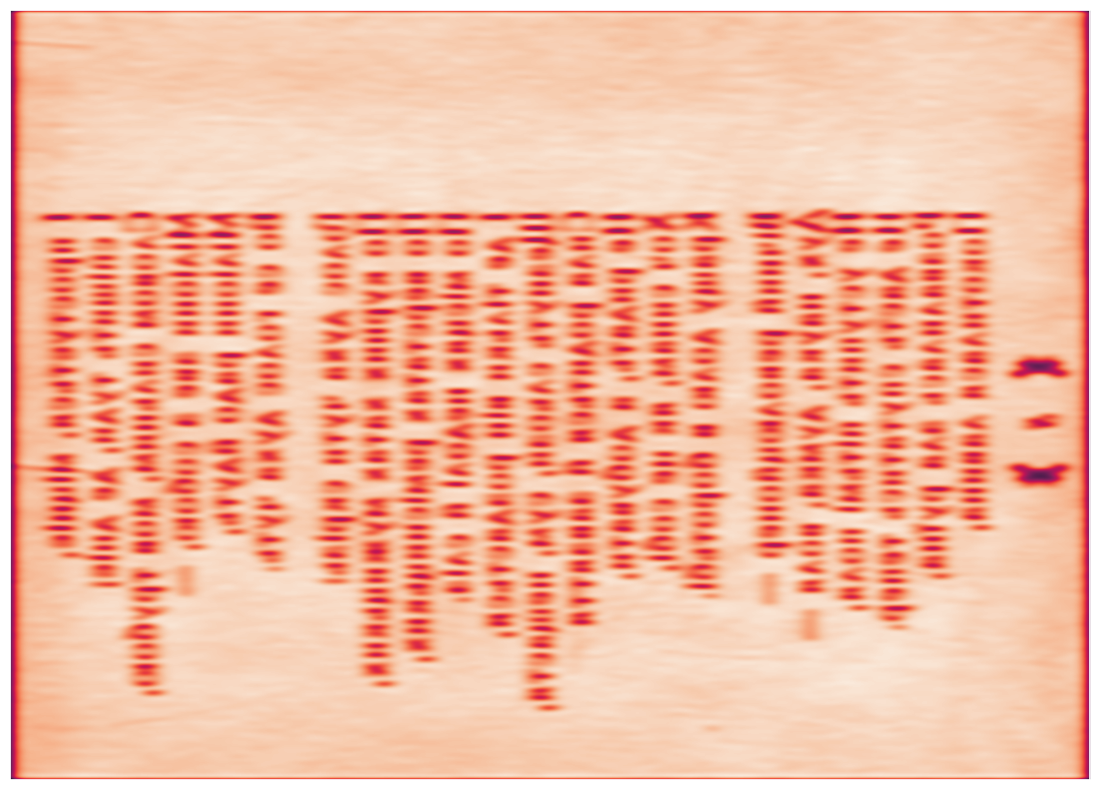

In [54]:
img_filtered = filter_image(img_gray, kernel_size, sigma, theta)
img_normalized = normalize_image(img_filtered)
show_image(img_normalized)

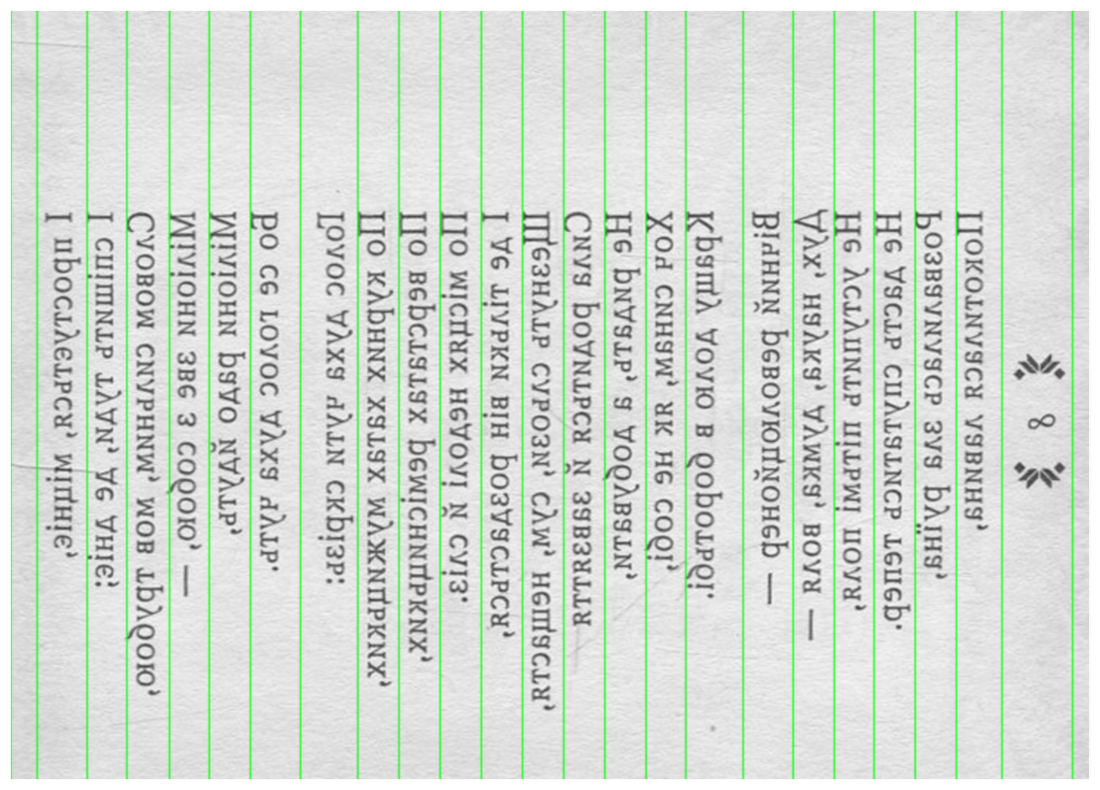

In [55]:
sum_array = apply_sum_function(img_normalized)
smoothed_signal = smooth(sum_array, window_len=smooth_window_len)
peaks = find_peaks(smoothed_signal, threshold * np.max(smoothed_signal))

merged_peaks = merge_adjacent_peaks(peaks, peak_min_distance)

img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)  # Конвертація в BGR
for peak in peaks:
    img_gray = cv2.line(img_gray, (peak, 0), (peak, img_gray.shape[0]), (0, 255, 0), 1)

img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)  # Конвертація в RGB для відображення
show_image(img_gray, cmap='gray')
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_RGB2GRAY)  # Конвертація назад в сірий

x1= 0 , x2= 13 , Diff=  13
x1= 13 , x2= 52 , Diff=  39
x1= 52 , x2= 79 , Diff=  27
x1= 79 , x2= 108 , Diff=  29
x1= 108 , x2= 135 , Diff=  27
x1= 135 , x2= 163 , Diff=  28
x1= 163 , x2= 197 , Diff=  34
x1= 197 , x2= 236 , Diff=  39
x1= 236 , x2= 264 , Diff=  28
x1= 264 , x2= 292 , Diff=  28
x1= 292 , x2= 320 , Diff=  28
x1= 320 , x2= 348 , Diff=  28
x1= 348 , x2= 376 , Diff=  28
x1= 376 , x2= 404 , Diff=  28
x1= 404 , x2= 432 , Diff=  28
x1= 432 , x2= 459 , Diff=  27
x1= 459 , x2= 498 , Diff=  39
x1= 498 , x2= 532 , Diff=  34
x1= 532 , x2= 560 , Diff=  28
x1= 560 , x2= 587 , Diff=  27
x1= 587 , x2= 615 , Diff=  28
x1= 615 , x2= 643 , Diff=  28
x1= 643 , x2= 674 , Diff=  31
x1= 674 , x2= 722 , Diff=  48


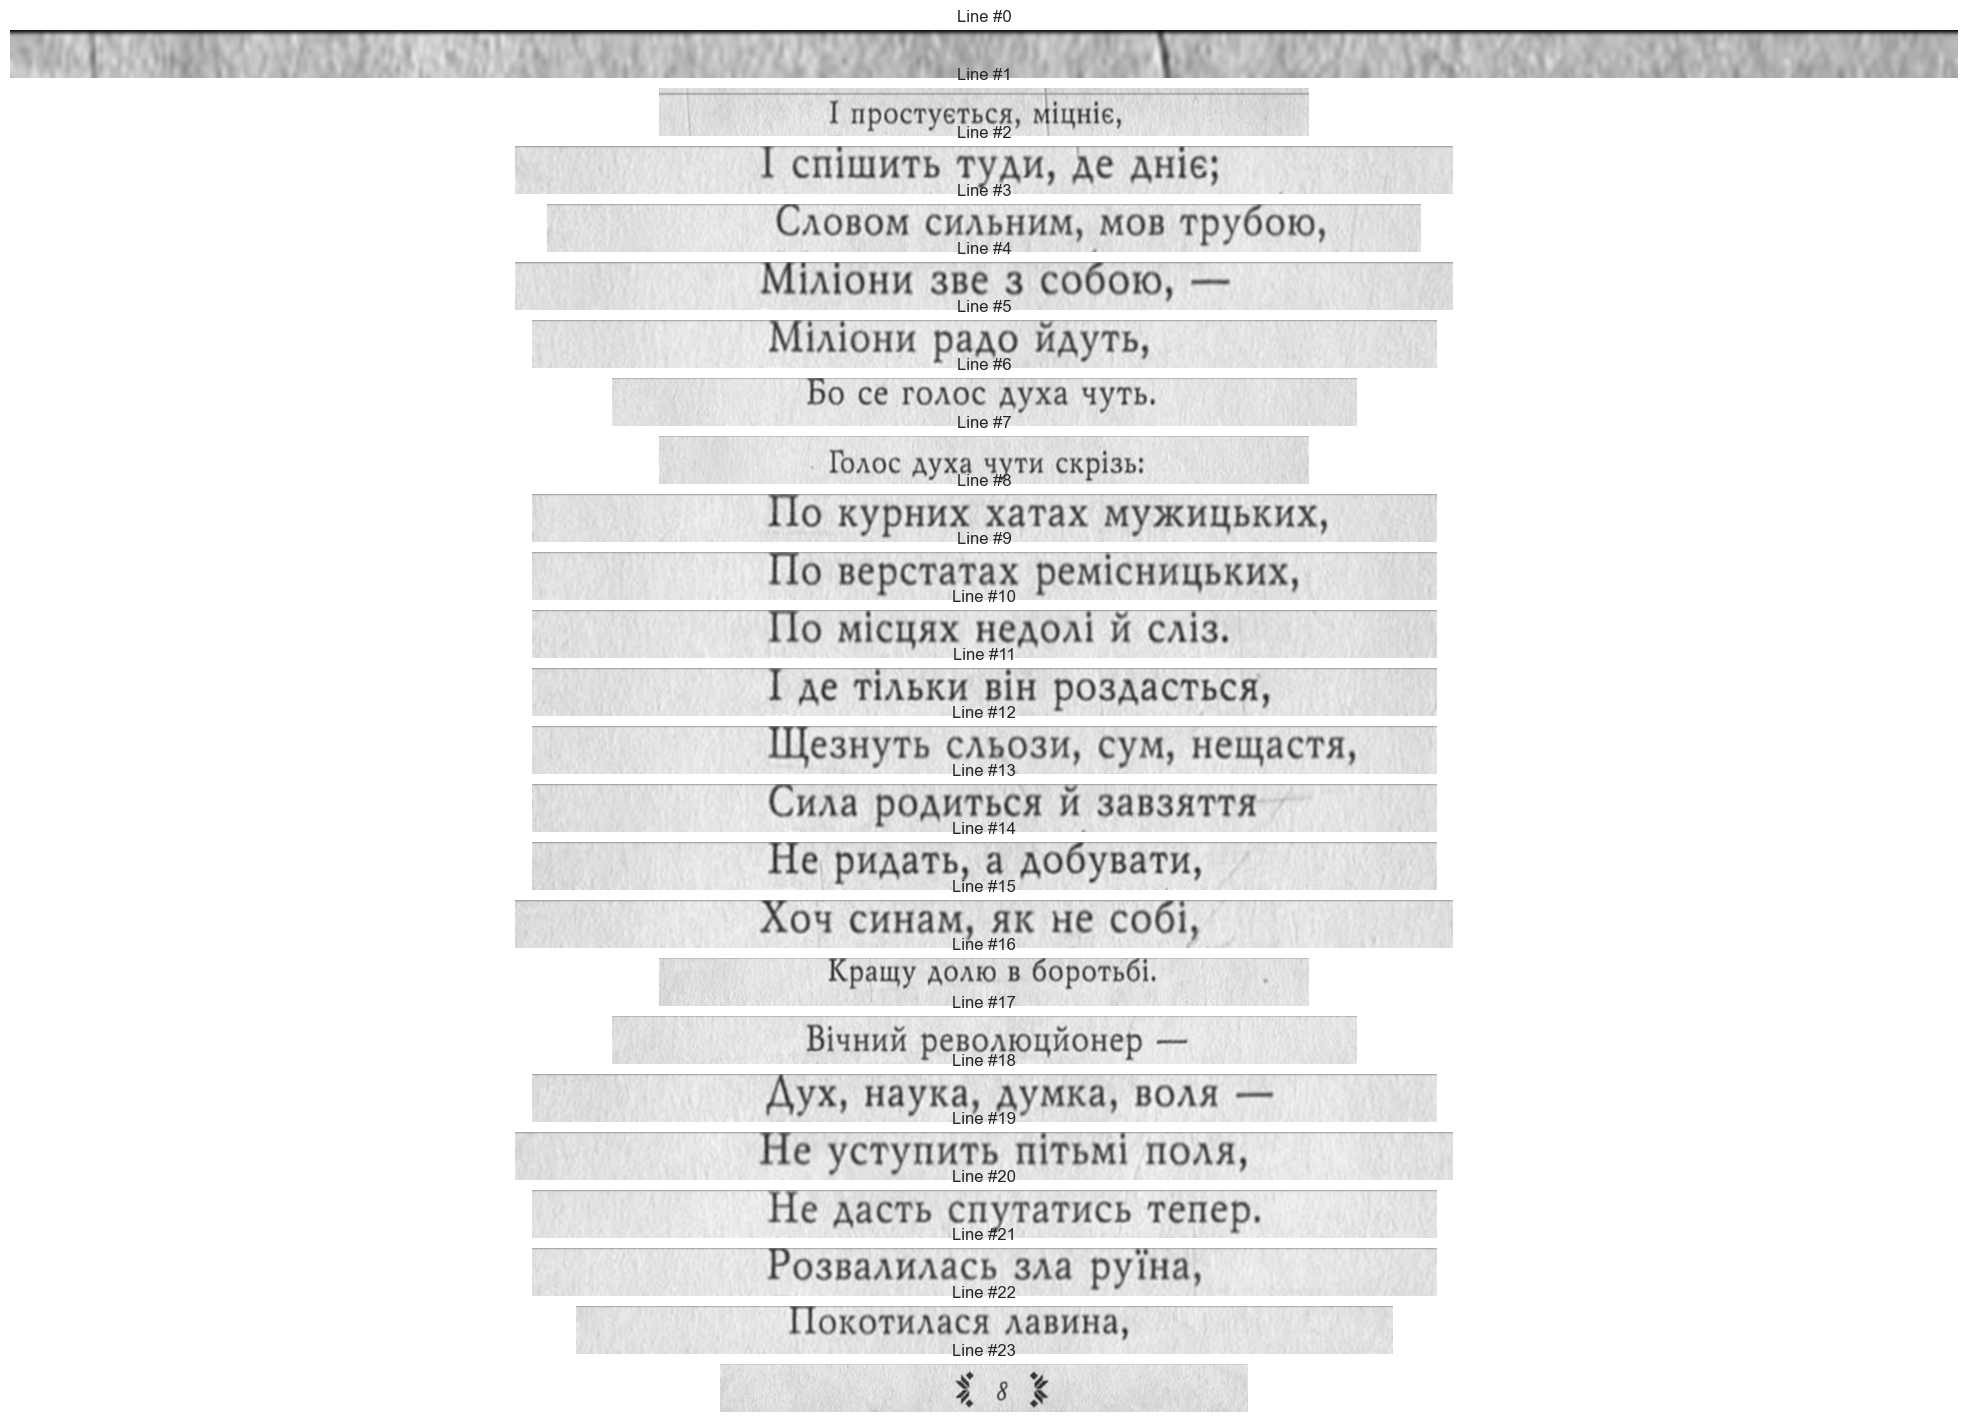

In [56]:
found_lines = crop_text_to_lines(img_gray, merged_peaks)
res_lines = transpose_lines(found_lines)
display_lines(res_lines, 'horizontal')

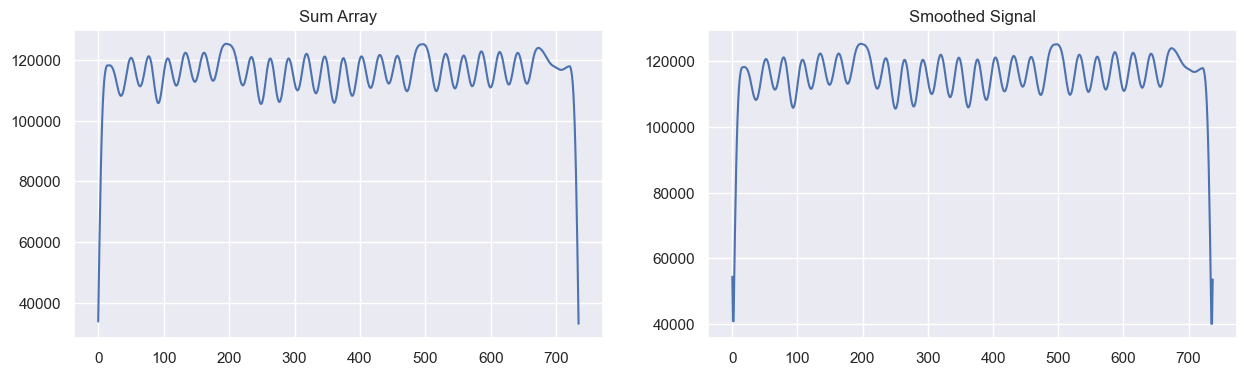

In [57]:

# Відображення графіків
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(sum_array)
plt.title("Sum Array")
plt.subplot(1, 2, 2)
plt.plot(smoothed_signal)
plt.title("Smoothed Signal")
plt.show()


In [ ]:
def get_lines(image_path, kernel_size=27, sigma=3, theta=9, smooth_window_len=4, threshold=0.3, peak_min_distance=20):
  img_gray = read_and_prepare_image(image_path)
  img_filtered = filter_image(img_gray, kernel_size, sigma, theta)
  img_normalized = normalize_image(img_filtered)
  sum_array = apply_sum_function(img_normalized)
  smoothed_signal = smooth(sum_array, window_len=smooth_window_len)
  peaks = find_peaks(smoothed_signal, threshold * np.max(smoothed_signal))

  merged_peaks = merge_adjacent_peaks(peaks, peak_min_distance)

  img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)  # Конвертація в BGR
  for peak in peaks:
      img_gray = cv2.line(img_gray, (peak, 0), (peak, img_gray.shape[0]), (0, 255, 0), 1)

  img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)  # Конвертація в RGB для відображення
  show_image(img_gray, cmap='gray')
  img_gray = cv2.cvtColor(img_gray, cv2.COLOR_RGB2GRAY)  # Конвертація назад в сірий
  found_lines = crop_text_to_lines(img_gray, merged_peaks)
  res_lines = transpose_lines(found_lines)
  
  return res_lines
  
  